In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 77 kB 6.8 MB/s 
     |████████████████████████████████| 6.5 MB 33.7 MB/s 
     |████████████████████████████████| 895 kB 49.7 MB/s 
     |████████████████████████████████| 596 kB 46.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import torch
import time
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# paramters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
fake = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/ISOT Dataset/Fake.csv')


In [ ]:
fake.shape

(23481, 4)

In [ ]:
true = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/ISOT Dataset/True.csv")

In [ ]:
true.shape

(21417, 4)

In [ ]:
# Add flag to track fake and real
fake['target'] = 1
true['target'] = 0

In [ ]:
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [ ]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [ ]:
data.head()

,title,text,subject,date,target
0,Turkey turns off Kurdish Rudaw channel in wake...,ANKARA (Reuters) - Turkey took the Kurdish tel...,worldnews,"September 25, 2017",0
1,IRANIAN SCIENTIST HANGED For “Revealing [Nucle...,Reckless Hillary couldn t have cared less abou...,politics,"Oct 6, 2016",1
2,‘Not Funny!’: Sean Spicer Whines About SNL Af...,The thin-skinned president-elect took his angr...,News,"January 16, 2017",1
3,MEDIA GOES CRAZY Over Hillary Wishing She Woul...,"The media is in an all out frenzy today, as th...",politics,"Aug 23, 2017",1
4,What will be in Obama's final budget proposal?,(Reuters) - President Barack Obama is set on T...,politicsNews,"February 4, 2016",0


In [ ]:
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Turkey turns off Kurdish Rudaw channel in wake...,ANKARA (Reuters) - Turkey took the Kurdish tel...,worldnews,0
1,IRANIAN SCIENTIST HANGED For “Revealing [Nucle...,Reckless Hillary couldn t have cared less abou...,politics,1
2,‘Not Funny!’: Sean Spicer Whines About SNL Af...,The thin-skinned president-elect took his angr...,News,1
3,MEDIA GOES CRAZY Over Hillary Wishing She Woul...,"The media is in an all out frenzy today, as th...",politics,1
4,What will be in Obama's final budget proposal?,(Reuters) - President Barack Obama is set on T...,politicsNews,0


In [ ]:
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,ANKARA (Reuters) - Turkey took the Kurdish tel...,worldnews,0
1,Reckless Hillary couldn t have cared less abou...,politics,1
2,The thin-skinned president-elect took his angr...,News,1
3,"The media is in an all out frenzy today, as th...",politics,1
4,(Reuters) - President Barack Obama is set on T...,politicsNews,0


In [ ]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,ankara (reuters) - turkey took the kurdish tel...,worldnews,0
1,reckless hillary couldn t have cared less abou...,politics,1
2,the thin-skinned president-elect took his angr...,News,1
3,"the media is in an all out frenzy today, as th...",politics,1
4,(reuters) - president barack obama is set on t...,politicsNews,0


In [ ]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

data.head()

,text,subject,target
0,ankara reuters turkey took the kurdish televi...,worldnews,0
1,reckless hillary couldn t have cared less abou...,politics,1
2,the thinskinned presidentelect took his angry ...,News,1
3,the media is in an all out frenzy today as the...,politics,1
4,reuters president barack obama is set on tues...,politicsNews,0


In [ ]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data.head()

,text,subject,target
0,ankara reuters turkey took kurdish television ...,worldnews,0
1,reckless hillary cared less seriousness exposi...,politics,1
2,thinskinned presidentelect took angry little f...,News,1
3,media frenzy today attempt help pump sales hor...,politics,1
4,reuters president barack obama set tuesday unv...,politicsNews,0


subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


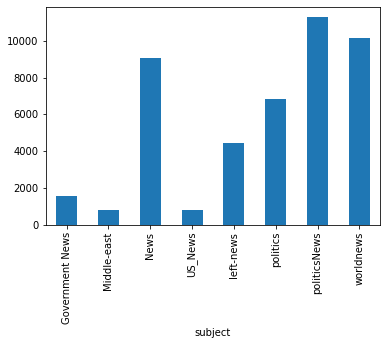

In [ ]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
0    21417
1    23481
Name: text, dtype: int64


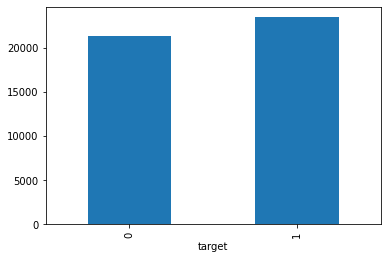

In [ ]:
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

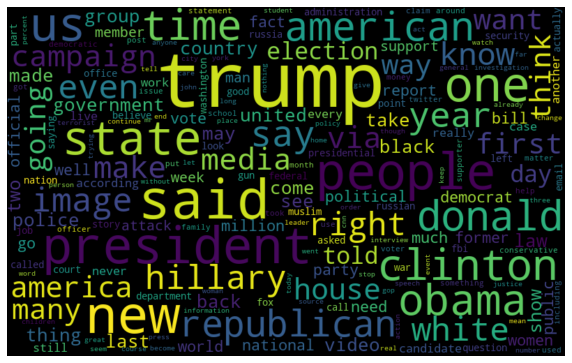

In [ ]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == 1]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

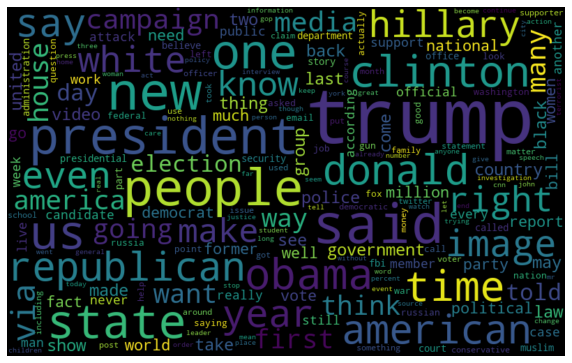

In [ ]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == 0]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

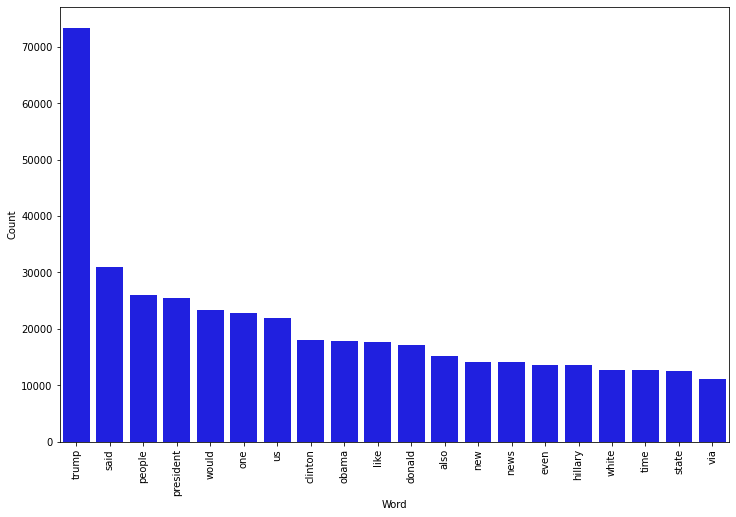

In [ ]:
#Most frequent words in fake news
counter(data[data["target"] == 1], "text", 20)

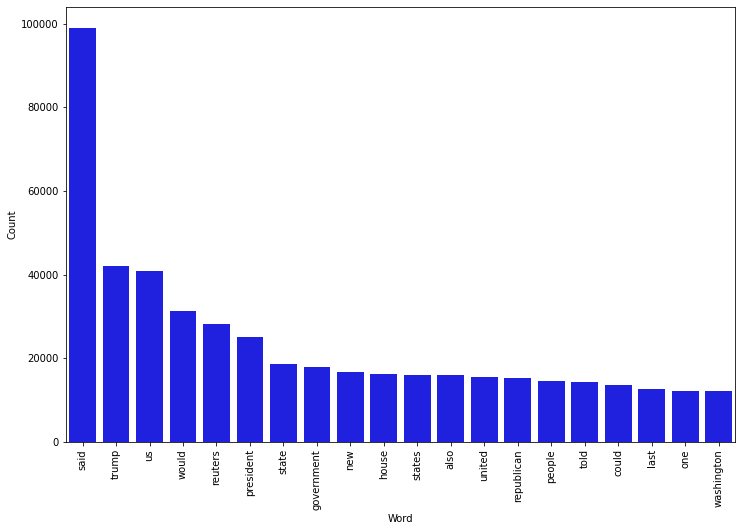

In [ ]:
# Most frequent words in real news
counter(data[data["target"] == 0], "text", 20)

In [ ]:
data.drop(['subject'],axis=1,inplace=True)
data.head()

,text,target
0,ankara reuters turkey took kurdish television ...,0
1,reckless hillary cared less seriousness exposi...,1
2,thinskinned presidentelect took angry little f...,1
3,media frenzy today attempt help pump sales hor...,1
4,reuters president barack obama set tuesday unv...,0


In [ ]:
data.head()

,text,target
0,ankara reuters turkey took kurdish television ...,0
1,reckless hillary cared less seriousness exposi...,1
2,thinskinned presidentelect took angry little f...,1
3,media frenzy today attempt help pump sales hor...,1
4,reuters president barack obama set tuesday unv...,0


In [ ]:
data.shape

(44898, 2)

In [ ]:
# check class distribution
data['target'].value_counts(normalize = True)

1    0.522985
0    0.477015
Name: target, dtype: float64

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['text'], data['target'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=data['target'])

# we will use train_text and train_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(train_text, train_labels, 
                                                                random_state=2018, 
                                                                test_size=0.3, 
                                                                stratify=train_labels)

In [ ]:
test=np.column_stack((temp_text,temp_labels))
import pandas as pd

test_pd=pd.DataFrame(test,columns=['text','label'])

In [ ]:
print(type(test_pd))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
test_pd.head()

,text,label
0,washington reuters us house representatives sp...,0
1,washington reuters republican representative t...,0
2,july 2016 donald trump jr met 42yearold russia...,1
3,cnn commentator van jones stood praise preside...,1
4,reuters president donald trump’s soninlaw seni...,0


In [ ]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
test_text

16097    find something original democrats trying fundr...
5309     since hillary making big announcement today th...
11487    thought donald trump constant stream offensive...
17474    black woman went fit rage spotted confederate ...
4018     washington reuters former us democratic presid...
                               ...                        
4499     robert parry consortium newsin wake donald tru...
23753    washington reuters us secretary state rex till...
27908    astana reuters syria un ambassador bashar alja...
15757    washingtonnew york reuters president donald tr...
1242     attendees 2017 conservative political action c...
Name: text, Length: 10776, dtype: object

In [ ]:
temp_text

25809    washington reuters us house representatives sp...
13390    washington reuters republican representative t...
3412     july 2016 donald trump jr met 42yearold russia...
39146    cnn commentator van jones stood praise preside...
29826    reuters president donald trump’s soninlaw seni...
                               ...                        
39790    london reuters britain less likely leave europ...
9569     clip kellyanne conway jen palmeieri getting ht...
16765    president donaldtrump accomplished first week ...
7684     washington reuters deputy us attorney general ...
10910    records available year unclear cast members vo...
Name: text, Length: 8980, dtype: object

In [ ]:
print(type(test_text))
print(type(test_labels))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
# sample data
text = ["this is a bert model for fake news detection", "will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 2005, 8275, 2739, 10788, 102], [101, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]}


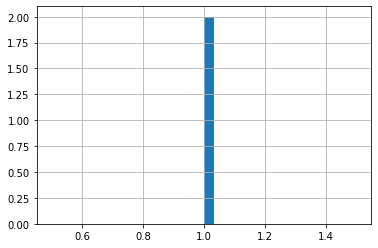

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in data]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 25

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
#define a batch size
batch_size = 128

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 0.01)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced',classes= np.unique(train_labels),y= train_labels)

print(class_wts)

[1.04821105 0.95602875]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

 #returns the loss and predictions
  return avg_loss, total_preds


In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    281.
  Batch   100  of    281.
  Batch   150  of    281.
  Batch   200  of    281.
  Batch   250  of    281.

Evaluating...
  Batch    50  of    197.
  Batch   100  of    197.
  Batch   150  of    197.

Training Loss: 0.471
Validation Loss: 0.117

 Epoch 2 / 5
  Batch    50  of    281.
  Batch   100  of    281.
  Batch   150  of    281.
  Batch   200  of    281.
  Batch   250  of    281.

Evaluating...
  Batch    50  of    197.
  Batch   100  of    197.
  Batch   150  of    197.

Training Loss: 0.197
Validation Loss: 0.108

 Epoch 3 / 5
  Batch    50  of    281.
  Batch   100  of    281.
  Batch   150  of    281.
  Batch   200  of    281.
  Batch   250  of    281.

Evaluating...
  Batch    50  of    197.
  Batch   100  of    197.
  Batch   150  of    197.

Training Loss: 0.184
Validation Loss: 0.124

 Epoch 4 / 5
  Batch    50  of    281.
  Batch   100  of    281.
  Batch   150  of    281.
  Batch   200  of    281.
  Batch   250  of    281.

Evaluatin

In [ ]:
import matplotlib.pyplot as plt

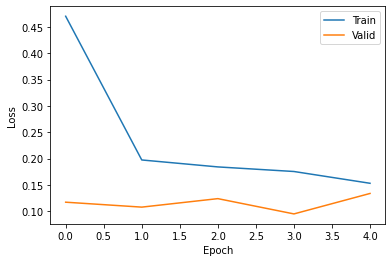

In [ ]:
plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
!pip install azureml-core

     |████████████████████████████████| 2.7 MB 4.9 MB/s 
     |████████████████████████████████| 86 kB 3.8 MB/s 
     |████████████████████████████████| 3.6 MB 45.3 MB/s 
     |████████████████████████████████| 178 kB 52.9 MB/s 
     |████████████████████████████████| 85 kB 3.9 MB/s 
     |████████████████████████████████| 40 kB 5.8 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 412 kB 49.7 MB/s 
     |████████████████████████████████| 146 kB 51.6 MB/s 
     |████████████████████████████████| 211 kB 45.7 MB/s 
     |████████████████████████████████| 1.8 MB 42.9 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 79 kB 8.2 MB/s 
     |████████████████████████████████| 928 kB 38.4 MB/s 
     |████████████████████████████████| 2.3 MB 33.8 MB/s 
     |████████████████████████████████| 141 kB 57.4 MB/s 
     |███████████████████████

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
import json
# import torch.optim as optim
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig
# from transformers import get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, f1_score, recall_score, precision_score, 
                             precision_recall_curve, confusion_matrix, matthews_corrcoef)
import matplotlib.pyplot as plt
from azureml.core import Workspace, Run, Dataset
from azureml.core.model import Model
import warnings
warnings.filterwarnings("ignore")

class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# pass the pre-trained BERT to our define architecture
test_model = BERT_Arch(bert)
test_model = test_model.to(device)
test_model.load_state_dict(torch.load('saved_weights.pt'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
test_pd.head()

,text,label
0,washington reuters us house representatives sp...,0
1,washington reuters republican representative t...,0
2,july 2016 donald trump jr met 42yearold russia...,1
3,cnn commentator van jones stood praise preside...,1
4,reuters president donald trump’s soninlaw seni...,0


In [ ]:
test_pd.dropna(inplace=True)
# print(test.head())

test_text = test_pd.text
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

max_seq_len = 25

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

with torch.no_grad():
  pred_proba = test_model(test_seq.to(device), test_mask.to(device))
  pred_proba = pred_proba.detach().cpu().numpy()

preds = np.argmax(pred_proba, axis = 1)

print([preds.tolist(), pred_proba.tolist()])

[[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = test_model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
test_y = test_y.reshape(10776,)
test_y.shape

torch.Size([10776])

In [ ]:
test_y1 = test_y[:8980]
test_y1 = test_y1.reshape(8980)
test_y1 = np.asarray(test_y1)
test_y1.shape

(8980,)

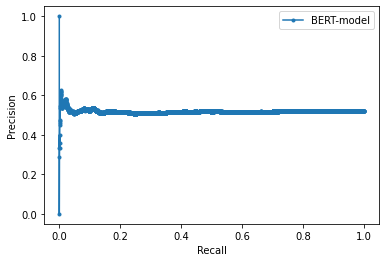


Matthews Corr Coef: -0.0019737451053265863
Precision: 0.5179554968054637
Recall: 0.5045064377682403
f-1 score: 0.4993851475610046
              precision    recall  f1-score   support

           0       0.48      0.49      0.49      4320
           1       0.52      0.50      0.51      4660

    accuracy                           0.50      8980
   macro avg       0.50      0.50      0.50      8980
weighted avg       0.50      0.50      0.50      8980



In [ ]:
# model's performance
precision_, recall_, proba = precision_recall_curve(test_y1,preds[:,-1])
preds = np.argmax(preds, axis = 1)

#plot precision-recall curve
plt.plot(recall_, precision_, marker='.', label='BERT-model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# optimal_proba_cutoff = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
# preds = [1 if i >= optimal_proba_cutoff else 0 for i in preds[:, -1]]

mcc = matthews_corrcoef(test_y1, preds)
tn, fp, fn, tp = confusion_matrix(test_y1, preds).ravel()
precision = precision_score(test_y1, preds)
recall = recall_score(test_y1, preds)
f1 = f1_score(test_y1, preds, average='weighted')

print("")
print("Matthews Corr Coef:", mcc)
print("Precision:", precision)
print("Recall:", recall)
print("f-1 score:", f1)

print(classification_report(test_y1, preds))